In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rc('font',family='malgun gothic')
plt.rc('axes',unicode_minus=False)
import seaborn as sns

# EDA
import klib

# Preprocessing&Feature Engineering
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from gensim.models import word2vec

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import kerastuner as kt

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression, BayesianRidge, Lars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from vecstack import StackingTransformer
from vecstack import stacking

# Eveluation
from sklearn.metrics import mean_squared_error # squared=False시 RMSE
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import pickle

### Read Data

In [2]:
x_train = pd.read_csv(os.path.abspath("../input")+'/x_train_raw.csv', index_col=0)
x_test = pd.read_csv(os.path.abspath("../input")+'/x_test_raw.csv', index_col=0)
df_train = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
y_train = pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949').set_index('custid')
df_test = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
test_id = df_test['custid'].unique()

In [3]:
x_train_cat = pd.read_csv(os.path.abspath("../input")+'/x_train_cat.csv', index_col=0)
x_test_cat = pd.read_csv(os.path.abspath("../input")+'/x_test_cat.csv', index_col=0)
x_train_cat = np.array(x_train_cat)
x_test_cat = np.array(x_test_cat)
x_train_cat2, x_dev_cat, y_train2, y_dev = train_test_split(x_train_cat, y_train, test_size=0.3, random_state=0)

In [4]:
x_train_num = pd.read_csv(os.path.abspath("../input")+'/x_train_num.csv', index_col=0)
x_test_num = pd.read_csv(os.path.abspath("../input")+'/x_test_num.csv', index_col=0)
x_train_num = np.array(x_train_num)
x_test_num = np.array(x_test_num)
x_train_num2, x_dev_num, y_train2, y_dev = train_test_split(x_train_num, y_train, test_size=0.3, random_state=0)

In [5]:
num_stk = pd.read_csv(os.path.abspath("../input")+'/numeric_stkenlas6lgbm14_ard_lgbm_cat.csv').age
cat_stk_dnn = pd.read_csv(os.path.abspath("../input")+'/categorical_stken14laslgbm_rid_lgbm_cat_dnn6.csv').age

In [6]:
num_stk_dev = pd.read_csv(os.path.abspath("../input")+'/numeric_stkenlas6lgbm14_ard_lgbm_cat_dev.csv')
cat_stk_dnn_dev = pd.read_csv(os.path.abspath("../input")+'/categorical_stken14laslgbm_rid_lgbm_cat_dnn6_dev.csv')

In [9]:
cat_copy1 = pd.read_csv(os.path.abspath("../input")+'/cat_copy1_dev.csv')

### Ensemble

In [28]:
pd.DataFrame(dict(zip(['num_stk_dev','cat_stk_dnn_dev','cat_copy1'],[num_stk_dev.age,cat_stk_dnn_dev.age,cat_copy1.age])))

,num_stk_dev,cat_stk_dnn_dev,cat_copy1
0,39.620176,41.028075,38.819840
1,28.143015,28.104800,30.081299
2,26.592611,27.800315,29.574303
3,33.260199,32.150721,32.323727
4,38.685654,39.331416,38.310212
...,...,...,...
6472,28.041933,29.160592,30.608262
6473,28.448304,29.688587,32.174802
6474,28.393726,28.895109,30.126484
6475,29.850521,29.852143,32.268204


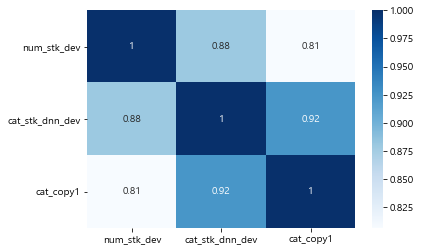

In [29]:
sns.heatmap(pd.DataFrame(dict(zip(['num_stk_dev','cat_stk_dnn_dev','cat_copy1'],[num_stk_dev.age,cat_stk_dnn_dev.age,cat_copy1.age]))).corr(),
           annot=True, cmap='Blues')
plt.show()

In [34]:
mean_squared_error((num_stk_dev+cat_copy1)/2,y_dev,squared=False)

8.262464160922816

In [35]:
weights_nc = []
rmse_best = 1000
for i in tqdm(range(0,101)):
    for j in range(0,101):
        if i+j!=100:
            continue
        pred = (num_stk_dev*i + cat_stk_dnn_dev*j)/100
        rmse = np.sqrt(mean_squared_error(y_dev, pred))
        if rmse < rmse_best:
            weights_nc = [i,j]
            rmse_best = rmse 
            print(rmse, i,j)     
print(rmse_best, weights_nc)

 28%|██████████████████████▏                                                         | 28/101 [00:00<00:00, 272.26it/s]

8.241100985207426 0 100
8.238024219033976 1 99
8.235053502613018 2 98
8.232188950753775 3 97
8.229430674319527 4 96
8.226778780206427 5 95
8.224233371323031 6 94
8.221794546570536 7 93
8.21946240082377 8 92
8.217237024912894 9 91
8.215118505605867 10 90
8.213106925591658 11 89
8.211202363464217 12 88
8.209404893707218 13 87
8.207714586679579 14 86
8.20613150860175 15 85
8.20465572154281 16 84
8.203287283408335 17 83
8.202026247929084 18 82
8.200872664650475 19 81
8.199826578922883 20 80
8.198888031892736 21 79
8.19805706049444 22 78
8.197333697443122 23 77
8.196717971228198 24 76
8.19620990610777 25 75
8.19580952210384 26 74
8.195516834998376 27 73
8.195331856330203 28 72
8.195254593392722 29 71


100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 304.01it/s]

8.195254593392722 [29, 71]


### Modeling

In [7]:
mix_dev = pd.DataFrame({'num':num_stk_dev.values.flatten()*29/100,'cat':cat_stk_dnn_dev.values.flatten()*71/100})
mix = pd.DataFrame({'num':num_stk.values.flatten()*29/100,'cat':cat_stk_dnn.values.flatten()*71/100})

In [8]:
mix.head()

,num,cat
0,10.415650,29.794056
1,11.934349,29.876847
2,8.326676,20.184667
3,9.354029,21.874165
4,7.782973,18.920300


In [55]:
mix_train, mix_test, y_mix, y_mix_dev = train_test_split(mix_dev,y_dev, test_size=0.3, random_state=0)

In [56]:
pbounds = {
    'alpha':(0,50)
}
def rid_opt(alpha):
    params = {
        'alpha':alpha
    }
    rid = Ridge(random_state=0, **params)
    rid.fit(mix_train,y_mix)
    score = mean_squared_error(rid.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_rid = BayesianOptimization(rid_opt, pbounds, random_state=0)
BO_rid.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -7.952    |  27.44    |
|  2        | -7.952    |  35.76    |
|  3        | -7.952    |  30.14    |
|  4        | -7.952    |  27.24    |
|  5        | -7.952    |  21.18    |
|  6        | -7.952    |  32.29    |
|  7        | -7.952    |  21.88    |
|  8        | -7.951    |  44.59    |
|  9        | -7.951    |  48.18    |
|  10       | -7.952    |  19.17    |
|  11       | -7.951    |  39.59    |
|  12       | -7.952    |  26.44    |
|  13       | -7.952    |  28.4     |
|  14       | -7.951    |  46.28    |
|  15       | -7.952    |  3.552    |
|  16       | -7.952    |  4.356    |
|  17       | -7.952    |  1.011    |
|  18       | -7.951    |  41.63    |
|  19       | -7.952    |  38.91    |
|  20       | -7.951    |  43.5     |
|  21       | -7.951    |  48.93    |
|  22       | -7.951    |  39.96    |
|  23       | -7.952    |  23.07    |
|  24       | -7.952    |  39.03    |
|  25       

In [57]:
pbounds = {
    'alpha':(0,50)
}
def las_opt(alpha):
    params = {
        'alpha':alpha
    }
    las = Lasso(random_state=0, **params)
    las.fit(mix_train,y_mix)
    score = mean_squared_error(las.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_las = BayesianOptimization(las_opt, pbounds, random_state=0)
BO_las.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -10.17    |  27.44    |
|  2        | -10.22    |  35.76    |
|  3        | -10.22    |  30.14    |
|  4        | -10.14    |  27.24    |
|  5        | -9.336    |  21.18    |
|  6        | -10.22    |  32.29    |
|  7        | -9.422    |  21.88    |
|  8        | -10.22    |  44.59    |
|  9        | -10.22    |  48.18    |
|  10       | -9.1      |  19.17    |
|  11       | -10.22    |  39.59    |
|  12       | -10.03    |  26.44    |
|  13       | -10.22    |  28.4     |
|  14       | -10.22    |  46.28    |
|  15       | -7.979    |  3.552    |
|  16       | -8.001    |  4.356    |
|  17       | -7.925    |  1.011    |
|  18       | -10.22    |  41.63    |
|  19       | -10.22    |  38.91    |
|  20       | -10.22    |  43.5     |
|  21       | -10.22    |  48.93    |
|  22       | -10.22    |  39.96    |
|  23       | -9.574    |  23.07    |
|  24       | -10.22    |  39.03    |
|  25       

In [58]:
pbounds = {
    'alpha':(0,50)
}
def ela_opt(alpha):
    params = {
        'alpha':alpha
    }
    ela = ElasticNet(random_state=0, **params)
    ela.fit(mix_train,y_mix)
    score = mean_squared_error(ela.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_ela = BayesianOptimization(ela_opt, pbounds, random_state=0)
BO_ela.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -9.151    |  27.44    |
|  2        | -9.523    |  35.76    |
|  3        | -9.277    |  30.14    |
|  4        | -9.142    |  27.24    |
|  5        | -8.839    |  21.18    |
|  6        | -9.374    |  32.29    |
|  7        | -8.875    |  21.88    |
|  8        | -9.865    |  44.59    |
|  9        | -9.99     |  48.18    |
|  10       | -8.734    |  19.17    |
|  11       | -9.678    |  39.59    |
|  12       | -9.103    |  26.44    |
|  13       | -9.197    |  28.4     |
|  14       | -9.925    |  46.28    |
|  15       | -7.978    |  3.552    |
|  16       | -8.005    |  4.356    |
|  17       | -7.926    |  1.011    |
|  18       | -9.757    |  41.63    |
|  19       | -9.651    |  38.91    |
|  20       | -9.826    |  43.5     |
|  21       | -10.01    |  48.93    |
|  22       | -9.693    |  39.96    |
|  23       | -8.936    |  23.07    |
|  24       | -9.656    |  39.03    |
|  25       

In [59]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def ard_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    ard = ARDRegression(**params)
    ard.fit(mix_train,y_mix)
    score = mean_squared_error(ard.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_ard = BayesianOptimization(ard_opt, pbounds, random_state=0)
BO_ard.maximize(init_points=50, n_iter=50) # init_points: exploration, n_iter: iteration

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -7.951    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -7.951    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -7.952    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -7.951    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -7.952    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -7.95     |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -7.951    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -7.951    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -7.946    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -7.952    |  33.53    |  10.52    |  1.2

|  58       | -7.949    |  21.33    |  10.07    |  5.45     |  1.876    |  286.5    |
|  59       | -7.947    |  14.28    |  10.9     |  5.852    |  0.4366   |  282.6    |
|  60       | -7.949    |  14.63    |  12.44    |  4.98     |  1.253    |  286.8    |
|  61       | -7.947    |  11.39    |  10.82    |  7.056    |  0.7653   |  284.6    |
|  62       | -7.946    |  27.11    |  23.48    |  6.99     |  0.5083   |  287.2    |
|  63       | -7.949    |  28.74    |  19.19    |  5.166    |  1.497    |  288.1    |
|  64       | -7.947    |  28.99    |  14.53    |  9.289    |  1.591    |  285.9    |
|  65       | -7.949    |  25.44    |  21.41    |  9.303    |  3.379    |  287.7    |
|  66       | -7.949    |  17.76    |  7.401    |  7.682    |  2.297    |  288.4    |
|  67       | -7.946    |  26.5     |  15.93    |  7.308    |  0.444    |  282.1    |
|  68       | -7.945    |  28.45    |  27.07    |  9.945    |  0.7602   |  290.4    |
|  69       | -7.944    |  29.74    |  28.53    |  9.8

In [60]:
pbounds = {
    'n_iter':(100,1000),
    'alpha_1':(0,50),
    'alpha_2':(0,50),
    'lambda_1':(0,10),
    'lambda_2':(0,10)
}
def bay_opt(n_iter,alpha_1,alpha_2,lambda_1,lambda_2):
    params = {
        'n_iter':int(round(n_iter)),
        'alpha_1':alpha_1,
        'alpha_2':alpha_2,
        'lambda_1':lambda_1,
        'lambda_2':lambda_2
    }
    bay = BayesianRidge(**params)
    bay.fit(mix_train,y_mix)
    score = mean_squared_error(bay.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_bay = BayesianOptimization(bay_opt, pbounds, random_state=0)
BO_bay.maximize(init_points=50, n_iter=50)

|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |  n_iter   |
-------------------------------------------------------------------------------------
|  1        | -7.951    |  27.44    |  35.76    |  6.028    |  5.449    |  481.3    |
|  2        | -7.951    |  32.29    |  21.88    |  8.918    |  9.637    |  445.1    |
|  3        | -7.951    |  39.59    |  26.44    |  5.68     |  9.256    |  163.9    |
|  4        | -7.951    |  4.356    |  1.011    |  8.326    |  7.782    |  883.0    |
|  5        | -7.951    |  48.93    |  39.96    |  4.615    |  7.805    |  206.4    |
|  6        | -7.95     |  32.0     |  7.168    |  9.447    |  5.218    |  473.2    |
|  7        | -7.951    |  13.23    |  38.71    |  4.562    |  5.684    |  116.9    |
|  8        | -7.951    |  30.88    |  30.6     |  6.169    |  9.437    |  713.6    |
|  9        | -7.946    |  17.98    |  21.85    |  6.976    |  0.6023   |  700.1    |
|  10       | -7.952    |  33.53    |  10.52    |  1.2

|  60       | -7.949    |  15.82    |  14.73    |  9.142    |  3.873    |  280.1    |
|  61       | -7.95     |  16.18    |  15.6     |  3.854    |  1.227    |  284.2    |
|  62       | -7.947    |  26.05    |  12.8     |  7.176    |  0.7214   |  281.6    |
|  63       | -7.948    |  27.23    |  23.25    |  7.738    |  1.333    |  283.2    |
|  64       | -7.947    |  28.99    |  14.53    |  9.289    |  1.591    |  285.9    |
|  65       | -7.949    |  25.44    |  21.41    |  9.303    |  3.379    |  287.7    |
|  66       | -7.947    |  15.79    |  10.69    |  7.804    |  1.3      |  287.0    |
|  67       | -7.946    |  26.5     |  15.93    |  7.308    |  0.444    |  282.1    |
|  68       | -7.946    |  12.03    |  13.69    |  6.443    |  0.4784   |  278.7    |
|  69       | -7.946    |  20.19    |  6.983    |  8.128    |  0.6253   |  292.1    |
|  70       | -7.946    |  17.47    |  12.78    |  5.13     |  0.01179  |  278.6    |
|  71       | -7.945    |  21.41    |  13.91    |  7.7

In [61]:
pbounds = {
    'n_estimators':(100,1000),
    'learning_rate':(0.000000000000000000000000001,1),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, min_child_weight,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha
    }
    lgbm = LGBMRegressor(random_state=0, **params)
    lgbm.fit(mix_train,y_mix)
    score = mean_squared_error(lgbm.predict(mix_test),y_mix_dev,squared=False)
    return -score
BO_lgbm = BayesianOptimization(lgbm_opt, pbounds, random_state=0)
BO_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -8.319    |  0.7744   |  0.7152   |  305.4    |  18.35    |  90.49    |  32.65    |  493.8    |  57.29    |  48.18    |  3.835    |  0.8959   |
|  2        | -8.306    |  0.7644   |  0.568    |  463.5    |  4.131    |  26.55    |  1.991    |  849.4    |  50.25    |  43.5     |  9.786    |  0.8996   |
|  3        | -8.615    |  0.7307   |  0.7805   |  67.95    |  21.2     |  37.24    |  47.29    |  569.7    |  27.71    |  13.24    |  7.743    |  0.7281   |
|  4        | -8.171    |  0.7842   |  0.01879  |  312.6    |  20.36    |  127.2    |  47.24    |  713.6    |  24.29    |  21.86    |  6.977    |  0.5301   |
|  5        | -8.316    |  0.8334   |  0.6706   |  1

|  31       | -8.541    |  0.5906   |  0.7885   |  37.86    |  22.91    |  158.0    |  39.09    |  333.5    |  25.18    |  29.38    |  2.729    |  0.6854   |
|  32       | -8.494    |  0.5985   |  0.4599   |  31.86    |  25.99    |  24.62    |  26.42    |  376.1    |  37.81    |  47.97    |  6.456    |  0.5177   |
|  33       | -8.636    |  0.7152   |  0.51     |  272.7    |  22.44    |  62.74    |  7.314    |  453.4    |  61.3     |  9.365    |  9.04     |  0.7719   |
|  34       | -8.595    |  0.7285   |  0.882    |  234.7    |  23.73    |  85.81    |  45.3     |  721.0    |  45.38    |  16.39    |  7.568    |  0.818    |
|  35       | -8.488    |  0.62     |  0.1605   |  400.2    |  30.77    |  97.05    |  29.96    |  872.0    |  30.35    |  47.59    |  5.758    |  0.9104   |
|  36       | -8.387    |  0.9544   |  0.8155   |  88.11    |  20.87    |  85.7     |  4.073    |  481.6    |  18.04    |  42.45    |  0.334    |  0.9795   |
|  37       | -8.497    |  0.6777   |  0.3567   |  1

|  63       | -8.634    |  0.5527   |  0.971    |  318.2    |  21.83    |  131.1    |  38.58    |  708.9    |  9.903    |  7.825    |  9.825    |  0.7519   |
|  64       | -8.292    |  0.8026   |  0.5392   |  339.0    |  15.3     |  146.8    |  11.92    |  889.9    |  40.97    |  46.88    |  5.387    |  0.7101   |
|  65       | -8.578    |  0.6962   |  0.5244   |  144.4    |  22.82    |  24.55    |  25.31    |  765.2    |  44.55    |  24.18    |  5.851    |  0.5296   |
|  66       | -8.128    |  0.8035   |  0.2129   |  177.0    |  17.24    |  40.27    |  36.61    |  153.8    |  5.445    |  8.454    |  9.276    |  0.6828   |
|  67       | -8.184    |  0.8384   |  0.112    |  178.9    |  18.74    |  45.56    |  27.86    |  158.5    |  13.97    |  4.978    |  7.933    |  0.6484   |
|  68       | -8.49     |  0.6005   |  0.5513   |  119.5    |  2.542    |  67.21    |  13.6     |  609.6    |  21.7     |  37.17    |  9.753    |  0.6029   |
|  69       | -8.073    |  0.954    |  0.8302   |  3

|  95       | -8.625    |  0.5246   |  0.3033   |  171.6    |  19.77    |  31.64    |  27.56    |  160.8    |  12.54    |  1.327    |  7.608    |  0.9171   |
|  96       | -8.504    |  0.6992   |  0.681    |  375.0    |  27.16    |  90.2     |  45.37    |  735.1    |  30.2     |  43.47    |  9.913    |  0.9478   |
|  97       | -8.493    |  0.7086   |  0.5778   |  489.4    |  16.92    |  84.19    |  2.388    |  675.7    |  44.97    |  48.15    |  7.521    |  0.8431   |
|  98       | -8.368    |  0.7782   |  0.553    |  387.4    |  19.06    |  118.0    |  1.649    |  522.6    |  42.33    |  40.45    |  2.603    |  0.6936   |
|  99       | -8.262    |  0.8701   |  0.2676   |  18.86    |  22.6     |  142.6    |  26.78    |  293.7    |  15.33    |  41.6     |  0.615    |  0.5104   |
|  100      | -8.511    |  0.5869   |  0.475    |  142.3    |  31.1     |  193.6    |  17.1     |  626.8    |  41.24    |  32.62    |  0.9758   |  0.7774   |


In [62]:
max_params_rid = BO_rid.max['params']
max_params_las = BO_las.max['params']
max_params_ela = BO_ela.max['params']
max_params_ard = BO_ard.max['params']
max_params_bay = BO_bay.max['params']
max_params_lgbm = BO_lgbm.max['params']

In [63]:
max_params_ard['n_iter'] = int(round(max_params_ard['n_iter']))

max_params_bay['n_iter'] = int(round(max_params_bay['n_iter']))

max_params_lgbm['num_leaves'] = int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators'] = int(round(max_params_lgbm['n_estimators']))
max_params_lgbm['max_depth'] = int(round(max_params_lgbm['max_depth']))
max_params_lgbm['min_child_samples'] = int(round(max_params_lgbm['min_child_samples']))
max_params_lgbm['min_child_weight'] = int(round(max_params_lgbm['min_child_weight']))
max_params_lgbm['max_bin'] = int(round(max_params_lgbm['max_bin']))
max_params_lgbm['subsample'] = max(min(max_params_lgbm['subsample'], 1), 0)
max_params_lgbm['colsample_bytree'] = max(min(max_params_lgbm['colsample_bytree'], 1), 0)

In [64]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained = [(name, reg.fit(mix_train,y_mix), float(mean_squared_error(reg.predict(mix_test),y_mix_dev,squared=False))) 
                    for name, reg in tqdm(regs_tuned.copy())]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:00<00:00, 54.51it/s]

Learning rate set to 0.051078
0:	learn: 10.3235198	total: 2.75ms	remaining: 2.75s
1:	learn: 10.1437129	total: 5ms	remaining: 2.5s
2:	learn: 9.9856427	total: 7.74ms	remaining: 2.57s
3:	learn: 9.8337711	total: 9.99ms	remaining: 2.49s
4:	learn: 9.6938133	total: 12.2ms	remaining: 2.42s
5:	learn: 9.5676000	total: 14.3ms	remaining: 2.37s
6:	learn: 9.4533433	total: 17ms	remaining: 2.41s
7:	learn: 9.3447391	total: 19.3ms	remaining: 2.39s
8:	learn: 9.2503968	total: 21.5ms	remaining: 2.37s
9:	learn: 9.1589848	total: 23.7ms	remaining: 2.34s
10:	learn: 9.0770744	total: 25.8ms	remaining: 2.32s
11:	learn: 9.0009170	total: 28ms	remaining: 2.31s
12:	learn: 8.9314298	total: 30.2ms	remaining: 2.29s
13:	learn: 8.8678880	total: 32.4ms	remaining: 2.28s
14:	learn: 8.8105388	total: 34.5ms	remaining: 2.27s
15:	learn: 8.7568040	total: 36.7ms	remaining: 2.26s
16:	learn: 8.7079780	total: 38.9ms	remaining: 2.25s
17:	learn: 8.6636882	total: 41.1ms	remaining: 2.24s
18:	learn: 8.6253661	total: 43.3ms	remaining: 2.24

162:	learn: 8.0997073	total: 337ms	remaining: 1.73s
163:	learn: 8.0986777	total: 339ms	remaining: 1.73s
164:	learn: 8.0978097	total: 341ms	remaining: 1.73s
165:	learn: 8.0967473	total: 343ms	remaining: 1.72s
166:	learn: 8.0948701	total: 345ms	remaining: 1.72s
167:	learn: 8.0942526	total: 347ms	remaining: 1.72s
168:	learn: 8.0920882	total: 350ms	remaining: 1.72s
169:	learn: 8.0909744	total: 352ms	remaining: 1.72s
170:	learn: 8.0892565	total: 354ms	remaining: 1.72s
171:	learn: 8.0877053	total: 356ms	remaining: 1.72s
172:	learn: 8.0870013	total: 358ms	remaining: 1.71s
173:	learn: 8.0850647	total: 360ms	remaining: 1.71s
174:	learn: 8.0841769	total: 362ms	remaining: 1.71s
175:	learn: 8.0831143	total: 365ms	remaining: 1.71s
176:	learn: 8.0810945	total: 367ms	remaining: 1.71s
177:	learn: 8.0798322	total: 370ms	remaining: 1.71s
178:	learn: 8.0778657	total: 372ms	remaining: 1.7s
179:	learn: 8.0761054	total: 374ms	remaining: 1.7s
180:	learn: 8.0745762	total: 376ms	remaining: 1.7s
181:	learn: 8.0

331:	learn: 7.8667715	total: 683ms	remaining: 1.37s
332:	learn: 7.8660066	total: 685ms	remaining: 1.37s
333:	learn: 7.8635561	total: 687ms	remaining: 1.37s
334:	learn: 7.8625430	total: 689ms	remaining: 1.37s
335:	learn: 7.8598380	total: 691ms	remaining: 1.36s
336:	learn: 7.8576238	total: 693ms	remaining: 1.36s
337:	learn: 7.8567620	total: 695ms	remaining: 1.36s
338:	learn: 7.8554094	total: 697ms	remaining: 1.36s
339:	learn: 7.8546284	total: 699ms	remaining: 1.36s
340:	learn: 7.8525208	total: 701ms	remaining: 1.35s
341:	learn: 7.8508893	total: 704ms	remaining: 1.35s
342:	learn: 7.8498186	total: 706ms	remaining: 1.35s
343:	learn: 7.8487127	total: 708ms	remaining: 1.35s
344:	learn: 7.8476594	total: 710ms	remaining: 1.35s
345:	learn: 7.8468380	total: 712ms	remaining: 1.35s
346:	learn: 7.8462177	total: 714ms	remaining: 1.34s
347:	learn: 7.8457335	total: 716ms	remaining: 1.34s
348:	learn: 7.8442060	total: 718ms	remaining: 1.34s
349:	learn: 7.8434346	total: 720ms	remaining: 1.34s
350:	learn: 

501:	learn: 7.6789729	total: 1.03s	remaining: 1.02s
502:	learn: 7.6776037	total: 1.03s	remaining: 1.02s
503:	learn: 7.6769311	total: 1.03s	remaining: 1.02s
504:	learn: 7.6758312	total: 1.04s	remaining: 1.01s
505:	learn: 7.6753133	total: 1.04s	remaining: 1.01s
506:	learn: 7.6738670	total: 1.04s	remaining: 1.01s
507:	learn: 7.6729006	total: 1.04s	remaining: 1.01s
508:	learn: 7.6717243	total: 1.04s	remaining: 1.01s
509:	learn: 7.6712352	total: 1.05s	remaining: 1.01s
510:	learn: 7.6698697	total: 1.05s	remaining: 1s
511:	learn: 7.6688867	total: 1.05s	remaining: 1s
512:	learn: 7.6685696	total: 1.05s	remaining: 1000ms
513:	learn: 7.6678348	total: 1.05s	remaining: 998ms
514:	learn: 7.6673108	total: 1.06s	remaining: 996ms
515:	learn: 7.6661365	total: 1.06s	remaining: 994ms
516:	learn: 7.6650943	total: 1.06s	remaining: 992ms
517:	learn: 7.6639312	total: 1.06s	remaining: 990ms
518:	learn: 7.6628921	total: 1.06s	remaining: 987ms
519:	learn: 7.6621054	total: 1.07s	remaining: 985ms
520:	learn: 7.661

673:	learn: 7.5328766	total: 1.38s	remaining: 667ms
674:	learn: 7.5319067	total: 1.38s	remaining: 665ms
675:	learn: 7.5306869	total: 1.38s	remaining: 663ms
676:	learn: 7.5299081	total: 1.38s	remaining: 661ms
677:	learn: 7.5289530	total: 1.39s	remaining: 659ms
678:	learn: 7.5283008	total: 1.39s	remaining: 657ms
679:	learn: 7.5280197	total: 1.39s	remaining: 655ms
680:	learn: 7.5271292	total: 1.39s	remaining: 653ms
681:	learn: 7.5260174	total: 1.4s	remaining: 651ms
682:	learn: 7.5257803	total: 1.4s	remaining: 649ms
683:	learn: 7.5256260	total: 1.4s	remaining: 646ms
684:	learn: 7.5253586	total: 1.4s	remaining: 644ms
685:	learn: 7.5249324	total: 1.4s	remaining: 642ms
686:	learn: 7.5244549	total: 1.41s	remaining: 640ms
687:	learn: 7.5242652	total: 1.41s	remaining: 638ms
688:	learn: 7.5227225	total: 1.41s	remaining: 636ms
689:	learn: 7.5214817	total: 1.41s	remaining: 634ms
690:	learn: 7.5209021	total: 1.41s	remaining: 632ms
691:	learn: 7.5204525	total: 1.42s	remaining: 630ms
692:	learn: 7.519

845:	learn: 7.3947876	total: 1.73s	remaining: 314ms
846:	learn: 7.3937107	total: 1.73s	remaining: 312ms
847:	learn: 7.3933153	total: 1.73s	remaining: 310ms
848:	learn: 7.3931239	total: 1.73s	remaining: 308ms
849:	learn: 7.3927278	total: 1.74s	remaining: 306ms
850:	learn: 7.3921023	total: 1.74s	remaining: 304ms
851:	learn: 7.3917225	total: 1.74s	remaining: 302ms
852:	learn: 7.3908633	total: 1.74s	remaining: 300ms
853:	learn: 7.3901652	total: 1.74s	remaining: 298ms
854:	learn: 7.3895786	total: 1.75s	remaining: 296ms
855:	learn: 7.3883472	total: 1.75s	remaining: 294ms
856:	learn: 7.3869528	total: 1.75s	remaining: 292ms
857:	learn: 7.3863989	total: 1.75s	remaining: 290ms
858:	learn: 7.3856802	total: 1.75s	remaining: 288ms
859:	learn: 7.3846133	total: 1.76s	remaining: 286ms
860:	learn: 7.3842546	total: 1.76s	remaining: 284ms
861:	learn: 7.3834216	total: 1.76s	remaining: 282ms
862:	learn: 7.3820324	total: 1.76s	remaining: 280ms
863:	learn: 7.3817127	total: 1.76s	remaining: 278ms
864:	learn: 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.95it/s]

931:	learn: 7.3349284	total: 1.9s	remaining: 139ms
932:	learn: 7.3336798	total: 1.9s	remaining: 137ms
933:	learn: 7.3326752	total: 1.91s	remaining: 135ms
934:	learn: 7.3323867	total: 1.91s	remaining: 133ms
935:	learn: 7.3313448	total: 1.91s	remaining: 131ms
936:	learn: 7.3312081	total: 1.91s	remaining: 129ms
937:	learn: 7.3303607	total: 1.92s	remaining: 127ms
938:	learn: 7.3295206	total: 1.92s	remaining: 125ms
939:	learn: 7.3287466	total: 1.92s	remaining: 123ms
940:	learn: 7.3285932	total: 1.92s	remaining: 120ms
941:	learn: 7.3278806	total: 1.92s	remaining: 118ms
942:	learn: 7.3257622	total: 1.93s	remaining: 116ms
943:	learn: 7.3253567	total: 1.93s	remaining: 114ms
944:	learn: 7.3243728	total: 1.93s	remaining: 112ms
945:	learn: 7.3241175	total: 1.93s	remaining: 110ms
946:	learn: 7.3232416	total: 1.93s	remaining: 108ms
947:	learn: 7.3226198	total: 1.94s	remaining: 106ms
948:	learn: 7.3218940	total: 1.94s	remaining: 104ms
949:	learn: 7.3205176	total: 1.94s	remaining: 102ms
950:	learn: 7.

In [65]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

regs_trained_for_submissions = [(name, reg.fit(mix_dev,y_dev)) for name, reg in tqdm(regs_tuned.copy())]

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Learning rate set to 0.054428
0:	learn: 10.2273377	total: 2.51ms	remaining: 2.5s
1:	learn: 10.0423268	total: 4.83ms	remaining: 2.41s
2:	learn: 9.8780121	total: 7.19ms	remaining: 2.39s
3:	learn: 9.7200314	total: 9.6ms	remaining: 2.39s
4:	learn: 9.5787265	total: 12ms	remaining: 2.39s
5:	learn: 9.4467653	total: 14.4ms	remaining: 2.38s
6:	learn: 9.3275493	total: 16.6ms	remaining: 2.35s
7:	learn: 9.2216753	total: 18.9ms	remaining: 2.34s
8:	learn: 9.1239912	total: 21.2ms	remaining: 2.33s
9:	learn: 9.0341689	total: 23.5ms	remaining: 2.32s
10:	learn: 8.9539677	total: 25.8ms	remaining: 2.32s
11:	learn: 8.8781171	total: 28.1ms	remaining: 2.31s
12:	learn: 8.8113889	total: 30.3ms	remaining: 2.3s
13:	learn: 8.7488849	total: 32.6ms	remaining: 2.3s
14:	learn: 8.6935839	total: 34.9ms	remaining: 2.29s
15:	learn: 8.6424188	total: 37.3ms	remaining: 2.3s
16:	learn: 8.5942065	total: 39.8ms	remaining: 2.3s
17:	learn: 8.5511777	total: 42.1ms	remaining: 2.29s
18:	learn: 8.5149902	total: 44.4ms	remaining: 2.29

225:	learn: 7.9906818	total: 512ms	remaining: 1.75s
226:	learn: 7.9900571	total: 515ms	remaining: 1.75s
227:	learn: 7.9893579	total: 517ms	remaining: 1.75s
228:	learn: 7.9883116	total: 519ms	remaining: 1.75s
229:	learn: 7.9871611	total: 521ms	remaining: 1.75s
230:	learn: 7.9860556	total: 524ms	remaining: 1.74s
231:	learn: 7.9850927	total: 526ms	remaining: 1.74s
232:	learn: 7.9845500	total: 529ms	remaining: 1.74s
233:	learn: 7.9835236	total: 531ms	remaining: 1.74s
234:	learn: 7.9825841	total: 533ms	remaining: 1.74s
235:	learn: 7.9818051	total: 536ms	remaining: 1.73s
236:	learn: 7.9809518	total: 538ms	remaining: 1.73s
237:	learn: 7.9798207	total: 540ms	remaining: 1.73s
238:	learn: 7.9789942	total: 543ms	remaining: 1.73s
239:	learn: 7.9772220	total: 545ms	remaining: 1.73s
240:	learn: 7.9767160	total: 547ms	remaining: 1.72s
241:	learn: 7.9760484	total: 549ms	remaining: 1.72s
242:	learn: 7.9740832	total: 552ms	remaining: 1.72s
243:	learn: 7.9728252	total: 554ms	remaining: 1.72s
244:	learn: 

459:	learn: 7.7798543	total: 1.04s	remaining: 1.22s
460:	learn: 7.7793027	total: 1.04s	remaining: 1.22s
461:	learn: 7.7783329	total: 1.04s	remaining: 1.22s
462:	learn: 7.7768574	total: 1.05s	remaining: 1.21s
463:	learn: 7.7754298	total: 1.05s	remaining: 1.21s
464:	learn: 7.7742745	total: 1.05s	remaining: 1.21s
465:	learn: 7.7733185	total: 1.05s	remaining: 1.21s
466:	learn: 7.7723664	total: 1.05s	remaining: 1.2s
467:	learn: 7.7720942	total: 1.06s	remaining: 1.2s
468:	learn: 7.7715734	total: 1.06s	remaining: 1.2s
469:	learn: 7.7695733	total: 1.06s	remaining: 1.2s
470:	learn: 7.7691418	total: 1.06s	remaining: 1.2s
471:	learn: 7.7679240	total: 1.07s	remaining: 1.19s
472:	learn: 7.7667241	total: 1.07s	remaining: 1.19s
473:	learn: 7.7659806	total: 1.07s	remaining: 1.19s
474:	learn: 7.7655586	total: 1.07s	remaining: 1.19s
475:	learn: 7.7649118	total: 1.07s	remaining: 1.18s
476:	learn: 7.7643531	total: 1.08s	remaining: 1.18s
477:	learn: 7.7635994	total: 1.08s	remaining: 1.18s
478:	learn: 7.763

691:	learn: 7.6189034	total: 1.56s	remaining: 695ms
692:	learn: 7.6181562	total: 1.56s	remaining: 692ms
693:	learn: 7.6179058	total: 1.56s	remaining: 690ms
694:	learn: 7.6175159	total: 1.57s	remaining: 688ms
695:	learn: 7.6171554	total: 1.57s	remaining: 686ms
696:	learn: 7.6166636	total: 1.57s	remaining: 683ms
697:	learn: 7.6163493	total: 1.57s	remaining: 681ms
698:	learn: 7.6156891	total: 1.58s	remaining: 679ms
699:	learn: 7.6153246	total: 1.58s	remaining: 677ms
700:	learn: 7.6145973	total: 1.58s	remaining: 675ms
701:	learn: 7.6143920	total: 1.58s	remaining: 672ms
702:	learn: 7.6140791	total: 1.59s	remaining: 670ms
703:	learn: 7.6135355	total: 1.59s	remaining: 668ms
704:	learn: 7.6132247	total: 1.59s	remaining: 666ms
705:	learn: 7.6122824	total: 1.59s	remaining: 663ms
706:	learn: 7.6111957	total: 1.59s	remaining: 661ms
707:	learn: 7.6105349	total: 1.6s	remaining: 659ms
708:	learn: 7.6098015	total: 1.6s	remaining: 657ms
709:	learn: 7.6090889	total: 1.6s	remaining: 654ms
710:	learn: 7.6

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.74it/s]

926:	learn: 7.4745440	total: 2.08s	remaining: 164ms
927:	learn: 7.4736113	total: 2.09s	remaining: 162ms
928:	learn: 7.4724319	total: 2.09s	remaining: 160ms
929:	learn: 7.4721907	total: 2.09s	remaining: 158ms
930:	learn: 7.4713253	total: 2.1s	remaining: 155ms
931:	learn: 7.4705856	total: 2.1s	remaining: 153ms
932:	learn: 7.4694965	total: 2.1s	remaining: 151ms
933:	learn: 7.4691326	total: 2.1s	remaining: 149ms
934:	learn: 7.4682302	total: 2.1s	remaining: 146ms
935:	learn: 7.4672716	total: 2.11s	remaining: 144ms
936:	learn: 7.4669385	total: 2.11s	remaining: 142ms
937:	learn: 7.4666019	total: 2.11s	remaining: 140ms
938:	learn: 7.4654831	total: 2.11s	remaining: 137ms
939:	learn: 7.4650273	total: 2.12s	remaining: 135ms
940:	learn: 7.4636510	total: 2.12s	remaining: 133ms
941:	learn: 7.4633820	total: 2.12s	remaining: 131ms
942:	learn: 7.4623614	total: 2.12s	remaining: 128ms
943:	learn: 7.4622562	total: 2.13s	remaining: 126ms
944:	learn: 7.4620594	total: 2.13s	remaining: 124ms
945:	learn: 7.460

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.74it/s]


In [66]:
regs_tuned = [Ridge(random_state=0, **max_params_rid),Lasso(random_state=0, **max_params_las),ElasticNet(random_state=0, **max_params_ela),
             ARDRegression(**max_params_ard),BayesianRidge(**max_params_bay),LGBMRegressor(random_state=0,**max_params_lgbm),CatBoostRegressor(random_state=0)]
regs_tuned = [(str(reg).split('(')[0], reg) for reg in regs_tuned]
regs_tuned[-1] = list(regs_tuned[-1])
regs_tuned[-1][0] = 'CatBoostRegressor'
regs_tuned[-1] = tuple(regs_tuned[-1])

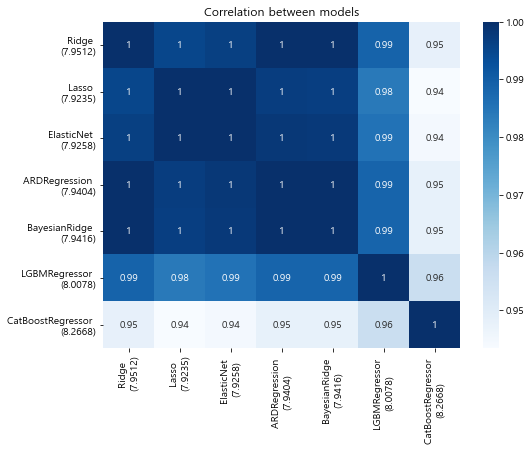

In [67]:
pred_results = []
for name, reg, reg_score in regs_trained:
    pred = list(reg.predict(mix_dev))
    name = f'{name} \n({reg_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

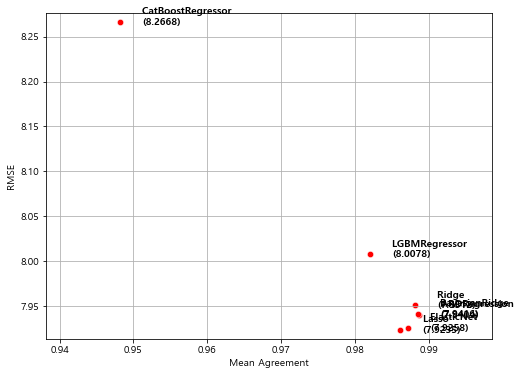

In [68]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [69]:
mean_squared_error(regs_trained[2][1].predict(mix_test),y_mix_dev,squared=False)

7.925774393430294

### Deep Neural Network
dnn.save('dnn_en')

In [38]:
def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(99)
    # seed를 잘 설정하면 성능이 더 잘 오른다.
    random.seed(9)
    tf.compat.v1.set_random_seed(16)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [57]:
i = int(round(mix_dev.shape[0] * 0.8,0))
mix_val, y_val = mix_dev[i:], y_dev[i:]
mix_3, y_mix_3 = mix_dev[:i], y_dev[:i]

In [59]:
def model_fn(hp):
    inputs = tf.keras.Input(shape=(mix_3.shape[1],))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 3, step=1)):
        x = tf.keras.layers.Dense(hp.Int('unit_'+str(i), 16, 64, step=16),
                               activation=hp.Choice('activation',['relu','tanh']))(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_'+str(i), 0, 0.7, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# keras tuner는 튜닝 종류가 4종류가 있음: hyperband, grid search, random search, bayesian optimization
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_root_mean_squared_error', direction="min"), 
                     max_epochs=30,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')
# objective: 튜닝 기준, hyperband_iterations:이거 자체에서 2번 반복
# overwrite: False시, 기존을 근거로 해 재학습 안시킴

tuner.search(mix_3, y_mix_3, validation_data=(mix_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping()])

Trial 180 Complete [00h 00m 05s]
val_root_mean_squared_error: 10.205755233764648

Best val_root_mean_squared_error So Far: 8.154484748840332
Total elapsed time: 00h 05m 44s
INFO:tensorflow:Oracle triggered exit


In [60]:
tuner.results_summary(1) # 1= 제일 성능이 좋은 놈

Results summary
Results in dnn_tuning\untitled_project
Showing 1 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
unit_0: 16
activation: relu
dropout_0: 0.0
unit_1: 32
dropout_1: 0.2
learning_rate: 0.01
unit_2: 48
dropout_2: 0.30000000000000004
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: c9841a68a6a38682711e065b78728c23
Score: 8.154484748840332


In [62]:
# Loss & RMSE
dnn = tuner.get_best_models(1)[0] # best model 중 가장 좋은 모델
dnn.evaluate(mix_val, y_val)

41/41 [==============================] - 0s 748us/step - loss: 67.9279 - root_mean_squared_error: 8.2400


[66.49562072753906, 8.154484748840332]

In [63]:
dnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0     

In [67]:
mean_squared_error((regs_trained[1][1].predict(mix_test)+dnn.predict(mix_test).flatten())/2,y_mix_dev,squared=False)

7.93704984839293

### Deployment

In [20]:
w0,w1 = weights_nc
pd.DataFrame({'custid': test_id, 'age': (num_stk*w0+cat_stk_dnn*w1)/100}).to_csv('Wnum_avg&Wcat_avg_dnn.csv', index=False)

In [72]:
selected = [#'LinearRegression',
            #'Ridge',
            'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            #'CatBoostRegressor'
            ]
model = [reg for name,reg in regs_trained_for_submissions if name in selected]
pd.DataFrame({'custid': test_id, 'age': model[0].predict(mix)}).to_csv('las_mix.csv', index=False)